**Tải và chuẩn bị dữ liệu CIC IDS 2018**

In [30]:
!curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
!unzip -o awscliv2.zip
! ./aws/install
!aws s3 sync --no-sign-request --region us-east-2 --exclude "*" --include "Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv" "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/"  ./Dataset
# Em chỉ thực hiện down 1 file cho bài lab này.

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: aws/dist/awscli/examples/cloudformation/wait/stack-create-complete.rst  
  inflating: aws/dist/awscli/examples/cloudformation/wait/stack-update-complete.rst  
  inflating: aws/dist/awscli/examples/cloudformation/wait/type-registration-complete.rst  
  inflating: aws/dist/awscli/examples/cloudformation/wait/stack-delete-complete.rst  
  inflating: aws/dist/awscli/examples/cloudformation/wait/stack-exists.rst  
  inflating: aws/dist/awscli/examples/cloudformation/wait/change-set-create-complete.rst  
  inflating: aws/dist/awscli/examples/cloudformation/wait/stack-import-complete.rst  
  inflating: aws/dist/awscli/examples/route53resolver/tag-resource.rst  
  inflating: aws/dist/awscli/examples/route53resolver/list-resolver-endpoint-ip-addresses.rst  
  inflating: aws/dist/awscli/examples/route53resolver/import-firewall-domains.rst  
  inflating: aws/dist/awscli/examples/route53resolver/list-firewall-domain-lists.rst  


**Xây dựng và huấn luyện mô hình phân loại nhị phân**

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.utils import get_file

# Chạy thử xem có những nhãn dán nào
data = pd.read_csv("/content/Dataset/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv", nrows=100000)
data.groupby('Label')['Label'].count()

Label
Benign                   47502
DoS attacks-GoldenEye    41508
DoS attacks-Slowloris    10990
Name: Label, dtype: int64

In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.utils import get_file

# Load Dataset
data = pd.read_csv("/content/Dataset/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv", nrows=100000)


# loại bỏ NA
data.dropna(inplace=True,axis=1)

# Loại bỏ Timestamp
data.drop('Timestamp', axis=1, inplace=True)

# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Encode cho cột chữ
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



#encoding feature vector
text_col = []

for i in data.columns:
  if i not in text_col:
    if i != 'Label':
      encode_numeric_zscore(data, i)

for x in text_col:
  encode_text_dummy(data, x)


data.dropna(inplace=True,axis=1)


# Xử lí nhãn
data.loc[data["Label"] != "Benign.", "Label"] = 1
data.loc[data["Label"] == "Benign.", "Label"] = 0
# data.loc[data["Label"] == "Brute Force -Web.", "Label"] = 1
# data.loc[data["Label"] == "Brute Force -XSS.", "Label"] = 2
# data.loc[data["Label"] == "SQL Injection.", "Label"] = 3
# data.loc[data["Label"] == "DoS attacks-GoldenEye.", "Label"] = 1
# data.loc[data["Label"] == "DoS attacks-Slowloris.", "Label"] = 2

y = data['Label']
data.drop('Label', axis=1, inplace = True)


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, y,  test_size=0.3, random_state=12)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

y_train = tf.one_hot(y_train.values, 2)
y_test = tf.one_hot(y_test.values, 2)


Normal train count: ((70000, 66), (70000,))
Normal test count: ((30000, 66), (30000,))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17026 (66.51 KB)
Trainable params: 17026 (66.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
55/55 [==============================] - 35s 602ms/step - loss: 0.0592 - accuracy: 0.9594 - val_loss: 6.3289e-09 - val_accuracy: 1.0000
Epoch 2/3
55/55 [==============================] - 31s 557ms/step - loss: 1.1566e-04 - accuracy: 1.0000 - val_loss: 1.0634e-09 - val_acc

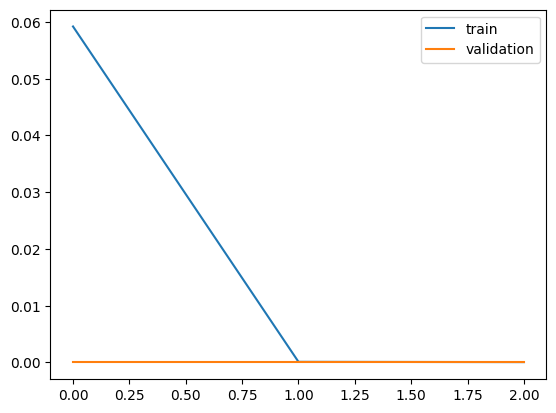

In [36]:
# Kiến trúc mô hình LSTM
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=2, activation='softmax'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()



# Huấn luyện mô hình
history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=1024,
    validation_split=0.2,
    shuffle = False
)



# Đánh giá mô hình Multiclass Classification
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

score1 = model.evaluate(x_train, y_train, batch_size=1024)

**Xây dựng và huấn luyện mô hình phân loại đa lớp**

Normal train count: ((70000, 66), (70000,))
Normal test count: ((30000, 66), (30000,))
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 17091 (66.76 KB)
Trainable params: 17091 (66.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
55/55 [==============================] - 28s 481ms/step - loss: 0.1992 - accuracy: 0.4834 - val_loss: 0.1776 - val_accuracy: 0.5961
Epoch 2/3
55/55 [==============================] - 24

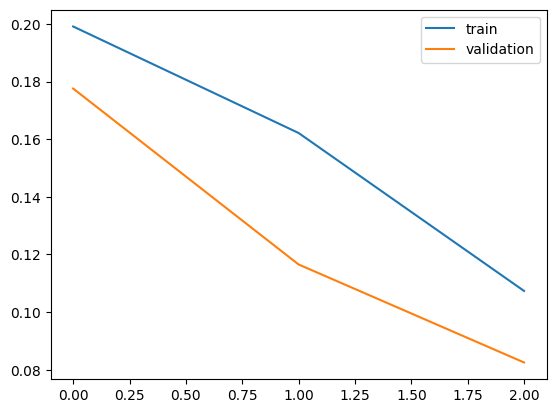

In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.utils import get_file

# Load Dataset
data = pd.read_csv("/content/Dataset/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv", nrows=100000)


# loại bỏ NA
data.dropna(inplace=True,axis=1)

# Loại bỏ Timestamp
data.drop('Timestamp', axis=1, inplace=True)

# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Encode cho cột chữ
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



#encoding feature vector
text_col = []

for i in data.columns:
  if i not in text_col:
    if i != 'Label':
      encode_numeric_zscore(data, i)

for x in text_col:
  encode_text_dummy(data, x)


data.dropna(inplace=True,axis=1)


# Xử lí nhãn
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])
data['Label'].unique()

X = data.drop(columns=['Label'])
Y = data['Label']


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y,  test_size=0.3, random_state=12)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

num_classes = len(np.unique(y_train))
y_train = tf.one_hot(y_train.values, num_classes)
y_test = tf.one_hot(y_test.values, num_classes)

x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
# Kiến trúc mô hình LSTM
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()



# Huấn luyện mô hình
history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=1024,
    validation_split=0.2,
    shuffle = False
)



# Đánh giá mô hình Multiclass Classification
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

score1 = model.evaluate(x_train, y_train, batch_size=1024)